<font color = blue><font size = 6> 실험설명 </font></font><br>
Pytorch의 모델 구성의 기본을 study하면서 DLinear를 implementation한 깃허브를 참고해서 이해하고 실험에 적용시켜본다 여기서 진행할 실험은<br>
<font color = blue>Online-Learning 즉, 정답 값이 들어올 때 훈련을 하고 그 정답 값을 이용해서 다음 값을 예측한 것이다</font><br>
[Reference]<br>
https://github.com/cure-lab/LTSF-Linear/blob/main/models/DLinear.py <br>
https://anweh.tistory.com/21

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
use_col = ['volumn']
data = pd.read_csv('../traffic/data/3.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,0.220168
1,0.221584
2,0.205680
3,0.185184
4,0.173464
...,...
38875,0.166704
38876,0.172936
38877,0.172976
38878,0.169264


In [4]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-DLinear')

['/hdd_1/sjlee/Paper_Project/online-learning-DLinear']

In [5]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [6]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)

        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [7]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['online-learning-DLinear']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['online-learning-DLinear']['pred_len']) # configure의 prediction length1
        
        # Decomposition Kernel Size
        kernel_size = 25
        self.decomposition = series_decomp(kernel_size)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = configs['online-learning-DLinear']['individual'] # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['online-learning-DLinear']['enc_in']) # 2) 이때 특성의개수
        
        if self.individual==True: # 특성 각각에 별도의 layer를 두자고 하면 -> Layer를 담아놓을 list가 필요함
            self.Linear_Seasonal = nn.ModuleList() # 모듈을 담아놓는 리스트 파이썬의 리스트처럼 인덱스로 접근 가능하다
            self.Linear_Trend = nn.ModuleList()
            
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))
        else: # 특성 각각에 별도의 layer를 두지 말자고 하면 하나씩의 Layer만 있으면 됨
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            
    def forward(self,x):
        
        # x의 size는 [Batch, Input_length, Channel]
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
#         seasonal_init,trend_init = seasonal_init.cpu(), trend_init.cpu() 
        # batch,input_size, sequence_length ex> tensor([[[1.6667, 2.0000, 2.6667, 3.6667],[1.6667, 2.0000, 2.6667, 3.6667]]])
        
        if self.individual==True:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],
                                              dtype = seasonal_init.dtype).to(seasonal_init.device)
                # seasonal_output을 저장할 Tensor를 만듦 Tip> ones도 비슷함
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),
                                            self.pred_len],dtype = trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):# feature의 갯수만큼 for문을 돌림 feature 각각에 대해서 linear layer에 투입
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                    # 위에서 seasonal init을 batch, input_size, sequence length로 바꿈 여기서 input size가 의미하는 바가 사실 
                    # feature의 갯수임 -> 따라서 각 피처마다 Linear Layer가 따로 있고 하나의 피처의 sequence length만큼의 데이터를 집어넣은후 학습하는 구조
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)    
            trend_output = self.Linear_Trend(trend_init)
        
        x = seasonal_output + trend_output
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [8]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [9]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

/tmp/ipykernel_502206/197408478.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [10]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-5)
criterion = SMAPE()
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,verbose = True)
                                       # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

Adjusting learning rate of group 0 to 1.0000e-05.


<font color =blue> zero_grad()의 이해 </font><br>
parameter들을 업데이트하는데,
한 루프에서 업데이트를 위해 loss.backward()를 호출하면 각 파라미터들의 .grad 값에 변화도가 저장이 된다.

이후 다음 루프에서 zero_grad()를 하지않고 역전파를 시키면 이전 루프에서 .grad에 저장된 값이 다음 루프의 업데이트에도 간섭을 해서 원하는 방향으로 학습이 안된다고 한다.

In [11]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

Adjusting learning rate of group 0 to 9.5000e-06.
smape 17.643183945999507 %
Adjusting learning rate of group 0 to 9.0250e-06.
smape 14.34334765618656 %
Adjusting learning rate of group 0 to 8.5737e-06.
smape 13.789263134114227 %
Adjusting learning rate of group 0 to 8.1451e-06.
smape 13.354262766695163 %
Adjusting learning rate of group 0 to 7.7378e-06.
smape 12.968558420301878 %
Adjusting learning rate of group 0 to 7.3509e-06.
smape 12.62197270640853 %
Adjusting learning rate of group 0 to 6.9834e-06.
smape 12.331799142803366 %
Adjusting learning rate of group 0 to 6.6342e-06.
smape 12.101708030578685 %
Adjusting learning rate of group 0 to 6.3025e-06.
smape 11.9141901737591 %
Adjusting learning rate of group 0 to 5.9874e-06.
smape 11.744832080620075 %
Adjusting learning rate of group 0 to 5.6880e-06.
smape 11.61021746259335 %
Adjusting learning rate of group 0 to 5.4036e-06.
smape 11.463528682439648 %
Adjusting learning rate of group 0 to 5.1334e-06.
smape 11.329967166073839 %
Adju

In [12]:
torch.manual_seed(42)

In [13]:
torch.arange(3*4)#np.arange()와 같은기능
A=torch.arange(3*4).view(1,1,-1).to(device)
print(A)
print(A[:,:,1:])
B=A[:,:,1:]
torch.cat([A,B],dim=2)

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')
tensor([[[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')


tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  1,  2,  3,  4,  5,
           6,  7,  8,  9, 10, 11]]], device='cuda:0')

In [14]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []
PATH = './my/Online_Dlearning_Path'
for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,1,-1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,1,sequence_length).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        if epochs == 0:
            prev_loss = loss
            
        elif loss < prev_loss:
            prev_loss=loss
            torch.save(model,PATH+'/best_model3.pt') #모델의 갱신
            
        running_loss = running_loss + loss.item()
    
    real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    
    model = torch.load(PATH+'/best_model3.pt')
    
    with torch.no_grad():
        model.eval()
        real_out = model(real_input)
            
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.19394389156707348 %
SMAPE 22.033335268497467 %
SMAPE 10.928528010845184 %
SMAPE 2.7547990903258324 %
SMAPE 1.5605133026838303 %
SMAPE 9.908732026815414 %
SMAPE 1.3308286666870117 %
SMAPE 3.532569855451584 %
SMAPE 5.868838354945183 %
SMAPE 2.4285422638058662 %
SMAPE 2.117251791059971 %
SMAPE 16.41785055398941 %
SMAPE 6.680203229188919 %
SMAPE 4.035245254635811 %
SMAPE 7.2602637112140656 %
SMAPE 0.9085200726985931 %
SMAPE 10.953360050916672 %
SMAPE 9.307094663381577 %
SMAPE 10.752102732658386 %
SMAPE 10.237590968608856 %
SMAPE 17.895328998565674 %
SMAPE 0.6988940760493279 %
SMAPE 10.682003200054169 %
SMAPE 15.228663384914398 %
SMAPE 12.352250516414642 %
SMAPE 2.147488296031952 %
SMAPE 12.918426096439362 %
SMAPE 8.005636185407639 %
SMAPE 8.008425682783127 %
SMAPE 16.339077055454254 %
SMAPE 18.05986613035202 %
SMAPE 7.5283437967300415 %
SMAPE 1.7112672328948975 %
SMAPE 7.309760898351669 %
SMAPE 7.521799951791763 %
SMAPE 0.5927516147494316 %
SMAPE 9.404586255550385 %
SMAPE 9.4951331

SMAPE 11.402877420186996 %
SMAPE 4.325684532523155 %
SMAPE 4.740039631724358 %
SMAPE 1.2138940393924713 %
SMAPE 21.2602898478508 %
SMAPE 6.656936556100845 %
SMAPE 16.763600707054138 %
SMAPE 4.997885227203369 %
SMAPE 0.6164213176816702 %
SMAPE 11.224809288978577 %
SMAPE 14.428317546844482 %
SMAPE 1.6175905242562294 %
SMAPE 8.018580079078674 %
SMAPE 14.119909703731537 %
SMAPE 3.757282719016075 %
SMAPE 1.222969125956297 %
SMAPE 17.56821870803833 %
SMAPE 5.982580780982971 %
SMAPE 13.637381792068481 %
SMAPE 18.82808655500412 %
SMAPE 16.31736159324646 %
SMAPE 14.002726972103119 %
SMAPE 0.18510191002860665 %
SMAPE 6.688077002763748 %
SMAPE 0.19653146155178547 %
SMAPE 2.679477632045746 %
SMAPE 5.559449270367622 %
SMAPE 7.575902342796326 %
SMAPE 2.873707376420498 %
SMAPE 7.984469830989838 %
SMAPE 8.21617990732193 %
SMAPE 6.656213104724884 %
SMAPE 4.528544470667839 %
SMAPE 1.7196021974086761 %
SMAPE 9.740312397480011 %
SMAPE 1.6469933092594147 %
SMAPE 18.273314833641052 %
SMAPE 16.74770265817642

SMAPE 5.507395416498184 %
SMAPE 1.4875298365950584 %
SMAPE 4.728073626756668 %
SMAPE 6.465068459510803 %
SMAPE 13.706880807876587 %
SMAPE 2.1288851276040077 %
SMAPE 4.037945345044136 %
SMAPE 8.031512796878815 %
SMAPE 0.5900396499782801 %
SMAPE 6.608474254608154 %
SMAPE 12.686073780059814 %
SMAPE 9.265941381454468 %
SMAPE 2.688901126384735 %
SMAPE 8.765949308872223 %
SMAPE 12.426359206438065 %
SMAPE 3.926147148013115 %
SMAPE 1.3238349929451942 %
SMAPE 2.3136580362915993 %
SMAPE 6.986004114151001 %
SMAPE 10.773826390504837 %
SMAPE 6.536384671926498 %
SMAPE 5.8360908180475235 %
SMAPE 5.815437063574791 %
SMAPE 6.970839202404022 %
SMAPE 7.643062621355057 %
SMAPE 12.569999694824219 %
SMAPE 0.8895644918084145 %
SMAPE 2.368311583995819 %
SMAPE 7.288797944784164 %
SMAPE 6.566702574491501 %
SMAPE 2.0777303725481033 %
SMAPE 8.218996971845627 %
SMAPE 1.0615171864628792 %
SMAPE 9.861622750759125 %
SMAPE 6.471602618694305 %
SMAPE 9.119918942451477 %
SMAPE 7.778940349817276 %
SMAPE 0.3750927047803998

SMAPE 2.52530537545681 %
SMAPE 4.348355904221535 %
SMAPE 8.012950420379639 %
SMAPE 12.641455233097076 %
SMAPE 5.797050893306732 %
SMAPE 2.3118341341614723 %
SMAPE 3.953409567475319 %
SMAPE 7.001374661922455 %
SMAPE 5.095816031098366 %
SMAPE 5.671604350209236 %
SMAPE 1.9314184784889221 %
SMAPE 1.5583392232656479 %
SMAPE 5.228996276855469 %
SMAPE 9.910538047552109 %
SMAPE 7.481019198894501 %
SMAPE 10.107801854610443 %
SMAPE 9.5893993973732 %
SMAPE 12.641249597072601 %
SMAPE 14.719890058040619 %
SMAPE 1.662876270711422 %
SMAPE 1.5203087590634823 %
SMAPE 4.533905163407326 %
SMAPE 8.520426601171494 %
SMAPE 8.008615672588348 %
SMAPE 6.583330035209656 %
SMAPE 0.4987972788512707 %
SMAPE 0.3051855368539691 %
SMAPE 12.161204218864441 %
SMAPE 8.88107717037201 %
SMAPE 16.290894150733948 %
SMAPE 10.31709760427475 %
SMAPE 1.2957667000591755 %
SMAPE 1.0802858509123325 %
SMAPE 9.042292088270187 %
SMAPE 13.03417831659317 %
SMAPE 11.894793808460236 %
SMAPE 3.6954689770936966 %
SMAPE 11.620205640792847 %

SMAPE 2.2083260118961334 %
SMAPE 8.60183835029602 %
SMAPE 7.571852952241898 %
SMAPE 11.17195188999176 %
SMAPE 6.365400552749634 %
SMAPE 3.588029369711876 %
SMAPE 5.2771154791116714 %
SMAPE 12.458181381225586 %
SMAPE 2.227628417313099 %
SMAPE 2.0845217630267143 %
SMAPE 5.28743676841259 %
SMAPE 5.1390524953603745 %
SMAPE 6.561221182346344 %
SMAPE 6.018554791808128 %
SMAPE 5.443786084651947 %
SMAPE 1.0714894160628319 %
SMAPE 6.718125194311142 %
SMAPE 0.5155374761670828 %
SMAPE 16.67286306619644 %
SMAPE 15.587203204631805 %
SMAPE 10.894725471735 %
SMAPE 0.6857952568680048 %
SMAPE 18.10169517993927 %
SMAPE 2.947911061346531 %
SMAPE 2.4863386526703835 %
SMAPE 11.119327694177628 %
SMAPE 5.506560578942299 %
SMAPE 8.718439191579819 %
SMAPE 13.670745491981506 %
SMAPE 12.417268007993698 %
SMAPE 2.4731503799557686 %
SMAPE 1.6166286543011665 %
SMAPE 7.033127546310425 %
SMAPE 2.716083824634552 %
SMAPE 2.046579122543335 %
SMAPE 1.9812673330307007 %
SMAPE 8.060678839683533 %
SMAPE 3.3734697848558426 %

SMAPE 8.913672715425491 %
SMAPE 3.399248421192169 %
SMAPE 5.205651745200157 %
SMAPE 6.383096426725388 %
SMAPE 7.635787129402161 %
SMAPE 5.621688812971115 %
SMAPE 21.105679869651794 %
SMAPE 13.166068494319916 %
SMAPE 3.129272162914276 %
SMAPE 2.795342542231083 %
SMAPE 3.7487871944904327 %
SMAPE 9.251043200492859 %
SMAPE 4.387258738279343 %
SMAPE 0.17756447196006775 %
SMAPE 1.881120726466179 %
SMAPE 3.6334753036499023 %
SMAPE 7.8671567142009735 %
SMAPE 8.345862478017807 %
SMAPE 0.6363441701978445 %
SMAPE 14.344915747642517 %
SMAPE 2.4868428707122803 %
SMAPE 14.414146542549133 %
SMAPE 12.973400950431824 %
SMAPE 3.768446668982506 %
SMAPE 11.383049935102463 %
SMAPE 4.174154996871948 %
SMAPE 0.8774673566222191 %
SMAPE 4.323575273156166 %
SMAPE 11.187579482793808 %
SMAPE 14.591747522354126 %
SMAPE 2.5082603096961975 %
SMAPE 16.22464954853058 %
SMAPE 8.719773590564728 %
SMAPE 5.4750047624111176 %
SMAPE 15.903322398662567 %
SMAPE 8.38819146156311 %
SMAPE 2.049700543284416 %
SMAPE 3.078579716384

SMAPE 4.7048743814229965 %
SMAPE 5.9579383581876755 %
SMAPE 0.8005101233720779 %
SMAPE 5.8713167905807495 %
SMAPE 9.637054800987244 %
SMAPE 7.375629246234894 %
SMAPE 15.055201947689056 %
SMAPE 11.727313697338104 %
SMAPE 3.898625075817108 %
SMAPE 10.275699943304062 %
SMAPE 2.0556900650262833 %
SMAPE 2.1755319088697433 %
SMAPE 6.839485466480255 %
SMAPE 3.898458555340767 %
SMAPE 6.102597713470459 %
SMAPE 8.139220625162125 %
SMAPE 9.073067456483841 %
SMAPE 7.439008355140686 %
SMAPE 8.47136676311493 %
SMAPE 0.13878955505788326 %
SMAPE 2.7530813589692116 %
SMAPE 4.871816188097 %
SMAPE 3.5656359046697617 %
SMAPE 6.189095601439476 %
SMAPE 8.722641319036484 %
SMAPE 13.604672253131866 %
SMAPE 10.411785542964935 %
SMAPE 0.6457630544900894 %
SMAPE 9.97253805398941 %
SMAPE 12.188255786895752 %
SMAPE 4.284292459487915 %
SMAPE 8.146216720342636 %
SMAPE 5.793335288763046 %
SMAPE 3.8736652582883835 %
SMAPE 19.603164494037628 %
SMAPE 10.679145902395248 %
SMAPE 4.046836867928505 %
SMAPE 4.322058334946632

SMAPE 3.5622749477624893 %
SMAPE 5.253565683960915 %
SMAPE 5.137195065617561 %
SMAPE 16.53369516134262 %
SMAPE 14.402537047863007 %
SMAPE 1.6560327261686325 %
SMAPE 3.014170378446579 %
SMAPE 8.87354463338852 %
SMAPE 3.8391783833503723 %
SMAPE 2.6478834450244904 %
SMAPE 8.332371711730957 %
SMAPE 0.2689882880076766 %
SMAPE 0.193664338439703 %
SMAPE 8.627967536449432 %
SMAPE 5.735370516777039 %
SMAPE 13.213421404361725 %
SMAPE 5.076546221971512 %
SMAPE 5.007202923297882 %
SMAPE 5.334880948066711 %
SMAPE 7.646527886390686 %
SMAPE 0.9392291307449341 %
SMAPE 0.794096477329731 %
SMAPE 2.917925640940666 %
SMAPE 2.0843397825956345 %
SMAPE 7.021524757146835 %
SMAPE 4.117658734321594 %
SMAPE 7.2732336819171906 %
SMAPE 2.0066123455762863 %
SMAPE 2.057257294654846 %
SMAPE 1.0570747777819633 %
SMAPE 11.835236102342606 %
SMAPE 7.976438105106354 %
SMAPE 2.570309117436409 %
SMAPE 7.430141419172287 %
SMAPE 11.922107636928558 %
SMAPE 4.398620501160622 %
SMAPE 11.081637442111969 %
SMAPE 4.719381779432297 

SMAPE 1.2588231824338436 %
SMAPE 1.5728779137134552 %
SMAPE 1.2416844256222248 %
SMAPE 3.001345694065094 %
SMAPE 10.537704080343246 %
SMAPE 1.4501961879432201 %
SMAPE 1.9450530409812927 %
SMAPE 6.065847724676132 %
SMAPE 2.4805206805467606 %
SMAPE 5.176735669374466 %
SMAPE 2.4236995726823807 %
SMAPE 0.6447264924645424 %
SMAPE 0.2768381265923381 %
SMAPE 7.509317249059677 %
SMAPE 2.0225409418344498 %
SMAPE 1.37722697108984 %
SMAPE 2.160070836544037 %
SMAPE 5.631054565310478 %
SMAPE 4.9110788851976395 %
SMAPE 0.3617236390709877 %
SMAPE 3.671542927622795 %
SMAPE 1.2241941876709461 %
SMAPE 0.3934069536626339 %
SMAPE 10.380202531814575 %
SMAPE 0.27311297599226236 %
SMAPE 3.8718242198228836 %
SMAPE 9.67622771859169 %
SMAPE 14.073140919208527 %
SMAPE 5.207355320453644 %
SMAPE 0.4975234158337116 %
SMAPE 10.239201784133911 %
SMAPE 4.054872319102287 %
SMAPE 11.308921128511429 %
SMAPE 10.392718017101288 %
SMAPE 17.208127677440643 %
SMAPE 9.850409626960754 %
SMAPE 3.448885679244995 %
SMAPE 1.5235374

SMAPE 0.703533785417676 %
SMAPE 1.8367117270827293 %
SMAPE 3.1831391155719757 %
SMAPE 4.146742448210716 %
SMAPE 5.566826835274696 %
SMAPE 10.408849269151688 %
SMAPE 3.4506846219301224 %
SMAPE 7.130254805088043 %
SMAPE 5.376498028635979 %
SMAPE 3.271273896098137 %
SMAPE 1.1973018757998943 %
SMAPE 1.5719370916485786 %
SMAPE 6.146713346242905 %
SMAPE 3.5407472401857376 %
SMAPE 3.091420605778694 %
SMAPE 8.124742656946182 %
SMAPE 3.2727662473917007 %
SMAPE 7.589815557003021 %
SMAPE 4.001830890774727 %
SMAPE 2.086993306875229 %
SMAPE 2.8782913461327553 %
SMAPE 6.343046575784683 %
SMAPE 3.440761938691139 %
SMAPE 1.1438313871622086 %
SMAPE 24.295367300510406 %
SMAPE 18.717408180236816 %
SMAPE 14.296047389507294 %
SMAPE 5.430648475885391 %
SMAPE 5.023809149861336 %
SMAPE 4.035348072648048 %
SMAPE 3.8101572543382645 %
SMAPE 4.440460726618767 %
SMAPE 3.7183523178100586 %
SMAPE 1.5495513565838337 %
SMAPE 11.31015494465828 %
SMAPE 15.215784311294556 %
SMAPE 0.147634360473603 %
SMAPE 2.1670725196599

SMAPE 4.952257126569748 %
SMAPE 5.652423948049545 %
SMAPE 8.269782364368439 %
SMAPE 6.069204211235046 %
SMAPE 0.9796278551220894 %
SMAPE 7.522168010473251 %
SMAPE 2.4255404248833656 %
SMAPE 21.917447447776794 %
SMAPE 6.615409255027771 %
SMAPE 7.634744048118591 %
SMAPE 8.220340311527252 %
SMAPE 14.716428518295288 %
SMAPE 17.995671927928925 %
SMAPE 4.6735163778066635 %
SMAPE 9.544295817613602 %
SMAPE 0.5692197009921074 %
SMAPE 4.762036353349686 %
SMAPE 15.672697126865387 %
SMAPE 15.274497866630554 %
SMAPE 14.160186052322388 %
SMAPE 9.381389617919922 %
SMAPE 12.516659498214722 %
SMAPE 14.438635110855103 %
SMAPE 2.3410625755786896 %
SMAPE 2.1591586992144585 %
SMAPE 17.666153609752655 %
SMAPE 2.196449786424637 %
SMAPE 13.690342009067535 %
SMAPE 11.916625499725342 %
SMAPE 15.330390632152557 %
SMAPE 8.146874606609344 %
SMAPE 19.569139182567596 %
SMAPE 12.107601761817932 %
SMAPE 0.14111141208559275 %
SMAPE 1.7956525087356567 %
SMAPE 9.890099614858627 %
SMAPE 7.506587356328964 %
SMAPE 4.6109963

SMAPE 6.445606052875519 %
SMAPE 10.220363736152649 %
SMAPE 13.165736198425293 %
SMAPE 12.958979606628418 %
SMAPE 13.1126269698143 %
SMAPE 1.3879744336009026 %
SMAPE 6.431782990694046 %
SMAPE 11.49069368839264 %
SMAPE 9.446488320827484 %
SMAPE 11.218968778848648 %
SMAPE 9.934965521097183 %
SMAPE 13.339826464653015 %
SMAPE 19.141466915607452 %
SMAPE 2.2111164405941963 %
SMAPE 7.790748029947281 %
SMAPE 12.0243139564991 %
SMAPE 11.199028044939041 %
SMAPE 11.368659138679504 %
SMAPE 10.339278727769852 %
SMAPE 11.757678538560867 %
SMAPE 6.030992791056633 %
SMAPE 16.4433091878891 %
SMAPE 15.022774040699005 %
SMAPE 0.4275815561413765 %
SMAPE 6.550166010856628 %
SMAPE 2.4573765695095062 %
SMAPE 0.4100444260984659 %
SMAPE 3.07027380913496 %
SMAPE 1.6955986618995667 %
SMAPE 2.277418226003647 %
SMAPE 5.59522919356823 %
SMAPE 10.018713772296906 %
SMAPE 14.379437267780304 %
SMAPE 2.4748723953962326 %
SMAPE 2.4693675339221954 %
SMAPE 3.741428628563881 %
SMAPE 13.829174637794495 %
SMAPE 9.2556737363338

SMAPE 1.9574981182813644 %
SMAPE 4.187506437301636 %
SMAPE 9.515886008739471 %
SMAPE 8.289684355258942 %
SMAPE 0.5505159962922335 %
SMAPE 6.941092759370804 %
SMAPE 3.003196232020855 %
SMAPE 2.2731592878699303 %
SMAPE 6.40648677945137 %
SMAPE 5.999231711030006 %
SMAPE 9.555327892303467 %
SMAPE 2.8252584859728813 %
SMAPE 4.1706860065460205 %
SMAPE 5.950165167450905 %
SMAPE 9.981044381856918 %
SMAPE 7.381013780832291 %
SMAPE 2.493324689567089 %
SMAPE 4.807986691594124 %
SMAPE 1.6756387427449226 %
SMAPE 0.49662329256534576 %
SMAPE 8.583492785692215 %
SMAPE 5.710138380527496 %
SMAPE 11.908460408449173 %
SMAPE 8.020120114088058 %
SMAPE 2.2858742624521255 %
SMAPE 4.740878939628601 %
SMAPE 2.5517279282212257 %
SMAPE 7.034837454557419 %
SMAPE 0.904611125588417 %
SMAPE 3.728850558400154 %
SMAPE 2.4696925655007362 %
SMAPE 2.678270637989044 %
SMAPE 11.397262662649155 %
SMAPE 9.333504736423492 %
SMAPE 1.84010099619627 %
SMAPE 3.974470868706703 %
SMAPE 2.331625297665596 %
SMAPE 2.6796115562319756 %


SMAPE 1.7642518505454063 %
SMAPE 0.38596135564148426 %
SMAPE 7.677197456359863 %
SMAPE 10.920368880033493 %
SMAPE 2.528720907866955 %
SMAPE 3.650343045592308 %
SMAPE 0.8426307700574398 %
SMAPE 10.077281296253204 %
SMAPE 2.2044140845537186 %
SMAPE 1.4425928704440594 %
SMAPE 1.7604345455765724 %
SMAPE 4.01097796857357 %
SMAPE 13.803628087043762 %
SMAPE 8.787056058645248 %
SMAPE 1.7165407538414001 %
SMAPE 6.296800822019577 %
SMAPE 4.300050437450409 %
SMAPE 6.356173008680344 %
SMAPE 0.3469513729214668 %
SMAPE 0.44608982279896736 %
SMAPE 1.072350237518549 %
SMAPE 2.3693393915891647 %
SMAPE 4.774513468146324 %
SMAPE 3.886568173766136 %
SMAPE 0.3675839165225625 %
SMAPE 4.361055418848991 %
SMAPE 4.690321907401085 %
SMAPE 5.016517266631126 %
SMAPE 7.604090869426727 %
SMAPE 6.345820426940918 %
SMAPE 5.482351407408714 %
SMAPE 10.928229987621307 %
SMAPE 0.5758370272815228 %
SMAPE 1.2031249701976776 %
SMAPE 3.3729199320077896 %
SMAPE 3.869735449552536 %
SMAPE 4.661876335740089 %
SMAPE 4.09718863666

SMAPE 12.90673315525055 %
SMAPE 18.788619339466095 %
SMAPE 2.995491586625576 %
SMAPE 2.227477915585041 %
SMAPE 9.683938324451447 %
SMAPE 12.415802478790283 %
SMAPE 11.624389886856079 %
SMAPE 0.20058583468198776 %
SMAPE 11.363757401704788 %
SMAPE 12.691086530685425 %
SMAPE 10.585103183984756 %
SMAPE 13.300137221813202 %
SMAPE 5.452536046504974 %
SMAPE 3.662659227848053 %
SMAPE 12.384738773107529 %
SMAPE 11.263719946146011 %
SMAPE 8.667629957199097 %
SMAPE 4.706517979502678 %
SMAPE 11.489693075418472 %
SMAPE 8.2840695977211 %
SMAPE 3.1128358095884323 %
SMAPE 5.220934376120567 %
SMAPE 7.964498549699783 %
SMAPE 5.901005119085312 %
SMAPE 0.7192079443484545 %
SMAPE 2.3804934695363045 %
SMAPE 2.9036885127425194 %
SMAPE 6.335874646902084 %
SMAPE 1.5115334652364254 %
SMAPE 1.107871625572443 %
SMAPE 0.26015937328338623 %
SMAPE 2.891375683248043 %
SMAPE 20.942795276641846 %
SMAPE 21.066762506961823 %
SMAPE 10.972762107849121 %
SMAPE 11.131179332733154 %
SMAPE 16.3967564702034 %
SMAPE 6.7443437874

SMAPE 4.333559796214104 %
SMAPE 8.294414728879929 %
SMAPE 6.472441554069519 %
SMAPE 0.843226071447134 %
SMAPE 8.496087044477463 %
SMAPE 13.413432240486145 %
SMAPE 16.059769690036774 %
SMAPE 0.8745313622057438 %
SMAPE 7.9727403819561005 %
SMAPE 9.063959866762161 %
SMAPE 15.244612097740173 %
SMAPE 11.906535178422928 %
SMAPE 3.1305231153964996 %
SMAPE 1.0647728107869625 %
SMAPE 11.763831973075867 %
SMAPE 9.594003111124039 %
SMAPE 15.511395037174225 %
SMAPE 0.1388269942253828 %
SMAPE 6.380634754896164 %
SMAPE 5.955015867948532 %
SMAPE 10.84434986114502 %
SMAPE 6.553014367818832 %
SMAPE 26.322856545448303 %
SMAPE 12.766017019748688 %
SMAPE 4.677221924066544 %
SMAPE 14.396688342094421 %
SMAPE 12.061592191457748 %
SMAPE 0.648587429895997 %
SMAPE 8.607472479343414 %
SMAPE 6.881573051214218 %
SMAPE 2.959621883928776 %
SMAPE 8.958588540554047 %
SMAPE 8.107897639274597 %
SMAPE 7.937133312225342 %
SMAPE 5.5907078087329865 %
SMAPE 1.9027350470423698 %
SMAPE 17.731401324272156 %
SMAPE 1.394654996693

SMAPE 11.043893545866013 %
SMAPE 7.815445214509964 %
SMAPE 2.894934080541134 %
SMAPE 1.5139181166887283 %
SMAPE 0.3830711590126157 %
SMAPE 2.986273355782032 %
SMAPE 8.849906921386719 %
SMAPE 1.2895063497126102 %
SMAPE 0.14376662438735366 %
SMAPE 2.942689135670662 %
SMAPE 0.5659954622387886 %
SMAPE 4.2845845222473145 %
SMAPE 11.307793110609055 %
SMAPE 6.622815132141113 %
SMAPE 5.754872411489487 %
SMAPE 3.093246929347515 %
SMAPE 3.916839137673378 %
SMAPE 1.136319525539875 %
SMAPE 1.8687216565012932 %
SMAPE 0.7485112641006708 %
SMAPE 5.634064599871635 %
SMAPE 6.065985560417175 %
SMAPE 5.483127012848854 %
SMAPE 6.878495216369629 %
SMAPE 5.896797031164169 %
SMAPE 8.782781660556793 %
SMAPE 11.472442001104355 %
SMAPE 4.0249887853860855 %
SMAPE 4.2275551706552505 %
SMAPE 10.337609052658081 %
SMAPE 6.165975332260132 %
SMAPE 12.141205370426178 %
SMAPE 7.40911066532135 %
SMAPE 1.708715409040451 %
SMAPE 8.84343609213829 %
SMAPE 5.829936638474464 %
SMAPE 9.324157983064651 %
SMAPE 2.7185047045350075

SMAPE 3.9962824434041977 %
SMAPE 17.85792112350464 %
SMAPE 20.886187255382538 %
SMAPE 16.259749233722687 %
SMAPE 4.047854244709015 %
SMAPE 4.80368472635746 %
SMAPE 6.157901883125305 %
SMAPE 1.9733401015400887 %
SMAPE 3.416180983185768 %
SMAPE 2.182125300168991 %
SMAPE 2.108105458319187 %
SMAPE 6.540839374065399 %
SMAPE 0.17602588050067425 %
SMAPE 3.3244140446186066 %
SMAPE 5.592295154929161 %
SMAPE 10.728228092193604 %
SMAPE 6.246744841337204 %
SMAPE 0.13817772269248962 %
SMAPE 3.9159931242465973 %
SMAPE 0.039892306085675955 %
SMAPE 2.6467010378837585 %
SMAPE 12.347275018692017 %
SMAPE 0.944303534924984 %
SMAPE 0.7083638571202755 %
SMAPE 2.028353698551655 %
SMAPE 8.097513765096664 %
SMAPE 7.247467339038849 %
SMAPE 3.1533438712358475 %
SMAPE 2.1871417760849 %
SMAPE 0.034076557494699955 %
SMAPE 10.221386700868607 %
SMAPE 9.431331604719162 %
SMAPE 2.904595248401165 %
SMAPE 5.3293876349925995 %
SMAPE 7.14569017291069 %
SMAPE 12.359100580215454 %
SMAPE 0.12917257845401764 %
SMAPE 5.26485890

SMAPE 1.1174295097589493 %
SMAPE 10.88917925953865 %
SMAPE 13.59165906906128 %
SMAPE 7.854621857404709 %
SMAPE 5.364496260881424 %
SMAPE 5.575965717434883 %
SMAPE 5.972274020314217 %
SMAPE 5.768593028187752 %
SMAPE 9.226041287183762 %
SMAPE 5.852648988366127 %
SMAPE 12.178365886211395 %
SMAPE 3.3416196703910828 %
SMAPE 2.648397535085678 %
SMAPE 6.361238658428192 %
SMAPE 11.999048292636871 %
SMAPE 14.776436984539032 %
SMAPE 4.077402502298355 %
SMAPE 3.7285570055246353 %
SMAPE 2.9198240488767624 %
SMAPE 8.904404938220978 %
SMAPE 16.42446517944336 %
SMAPE 4.204815998673439 %
SMAPE 2.6339443400502205 %
SMAPE 3.8473762571811676 %
SMAPE 7.0546954870224 %
SMAPE 13.084197044372559 %
SMAPE 7.566751539707184 %
SMAPE 1.9851136952638626 %
SMAPE 11.292855441570282 %
SMAPE 2.7522649616003036 %
SMAPE 13.063324987888336 %
SMAPE 2.7440905570983887 %
SMAPE 1.721232756972313 %
SMAPE 1.3874508440494537 %
SMAPE 5.918673053383827 %
SMAPE 16.684694588184357 %
SMAPE 5.556713417172432 %
SMAPE 7.529284805059433

SMAPE 1.0441779159009457 %
SMAPE 0.6505907978862524 %
SMAPE 1.4343890361487865 %
SMAPE 1.5156932175159454 %
SMAPE 20.49601376056671 %
SMAPE 6.754077970981598 %
SMAPE 6.027493998408318 %
SMAPE 5.74311763048172 %
SMAPE 5.949641764163971 %
SMAPE 15.51622450351715 %
SMAPE 11.556457728147507 %
SMAPE 4.819624498486519 %
SMAPE 5.7984646409749985 %
SMAPE 8.706767857074738 %
SMAPE 22.604049742221832 %
SMAPE 7.312452793121338 %
SMAPE 8.96104872226715 %
SMAPE 5.249826610088348 %
SMAPE 1.0804012417793274 %
SMAPE 20.579874515533447 %
SMAPE 7.225743681192398 %
SMAPE 5.7125043123960495 %
SMAPE 5.007631704211235 %
SMAPE 15.414953231811523 %
SMAPE 23.55104237794876 %
SMAPE 3.3867288380861282 %
SMAPE 5.914372950792313 %
SMAPE 8.092555403709412 %
SMAPE 5.202731490135193 %
SMAPE 17.13087558746338 %
SMAPE 0.4529458936303854 %
SMAPE 2.172914147377014 %
SMAPE 2.667713537812233 %
SMAPE 5.191043391823769 %
SMAPE 18.697789311408997 %
SMAPE 1.5991687774658203 %
SMAPE 12.609916925430298 %
SMAPE 21.129678189754486

SMAPE 16.821016371250153 %
SMAPE 8.082778751850128 %
SMAPE 0.4571235738694668 %
SMAPE 13.3700430393219 %
SMAPE 23.064100742340088 %
SMAPE 5.915488302707672 %
SMAPE 8.909425884485245 %
SMAPE 10.167159140110016 %
SMAPE 12.45439276099205 %
SMAPE 13.9874666929245 %
SMAPE 5.311880633234978 %
SMAPE 5.084772408008575 %
SMAPE 9.34605523943901 %
SMAPE 6.374386698007584 %
SMAPE 19.210726022720337 %
SMAPE 2.0048219710588455 %
SMAPE 6.152805685997009 %
SMAPE 6.809619069099426 %
SMAPE 12.564623355865479 %
SMAPE 15.474297106266022 %
SMAPE 1.9363701343536377 %
SMAPE 3.7978779524564743 %
SMAPE 10.821148008108139 %
SMAPE 9.981389343738556 %
SMAPE 19.200466573238373 %
SMAPE 2.814195677638054 %
SMAPE 9.635251760482788 %
SMAPE 14.49483036994934 %
SMAPE 11.004486680030823 %
SMAPE 16.088666021823883 %
SMAPE 10.710878670215607 %
SMAPE 5.862695723772049 %
SMAPE 1.627247966825962 %
SMAPE 9.54069048166275 %
SMAPE 24.11949634552002 %
SMAPE 3.3766426146030426 %
SMAPE 11.760050058364868 %
SMAPE 11.37157827615738 %

SMAPE 1.2977834790945053 %
SMAPE 2.6945507153868675 %
SMAPE 0.608299020677805 %
SMAPE 9.020376950502396 %
SMAPE 15.962536633014679 %
SMAPE 4.093221202492714 %
SMAPE 5.711137875914574 %
SMAPE 5.857762321829796 %
SMAPE 11.011700332164764 %
SMAPE 14.179196953773499 %
SMAPE 2.905697748064995 %
SMAPE 0.28853402473032475 %
SMAPE 0.6595810875296593 %
SMAPE 7.888155430555344 %
SMAPE 20.195390284061432 %
SMAPE 2.0204395055770874 %
SMAPE 3.8038115948438644 %
SMAPE 12.06337884068489 %
SMAPE 9.757904708385468 %
SMAPE 17.353585362434387 %
SMAPE 7.928243279457092 %
SMAPE 8.812656253576279 %
SMAPE 8.842766284942627 %
SMAPE 3.9092417806386948 %
SMAPE 20.9838405251503 %
SMAPE 5.497037246823311 %
SMAPE 7.968485355377197 %
SMAPE 3.8776222616434097 %
SMAPE 3.7567738443613052 %
SMAPE 4.799717292189598 %
SMAPE 3.1821001321077347 %
SMAPE 0.25322381407022476 %
SMAPE 0.4504370503127575 %
SMAPE 1.9099900498986244 %
SMAPE 12.7590611577034 %
SMAPE 1.2721584178507328 %
SMAPE 2.986033447086811 %
SMAPE 8.59764516353

SMAPE 4.935843124985695 %
SMAPE 6.362350285053253 %
SMAPE 2.1970367059111595 %
SMAPE 4.414375126361847 %
SMAPE 8.59072282910347 %
SMAPE 8.453430235385895 %
SMAPE 1.131666824221611 %
SMAPE 4.244343563914299 %
SMAPE 3.5479836165905 %
SMAPE 12.666673958301544 %
SMAPE 12.590160965919495 %
SMAPE 8.578118681907654 %
SMAPE 3.742387145757675 %
SMAPE 4.501809179782867 %
SMAPE 13.5531947016716 %
SMAPE 5.865498259663582 %
SMAPE 1.7953382804989815 %
SMAPE 5.086683854460716 %
SMAPE 3.519676625728607 %
SMAPE 7.3994942009449005 %
SMAPE 1.6539620235562325 %
SMAPE 3.033117763698101 %
SMAPE 0.01236289826920256 %
SMAPE 13.546119630336761 %
SMAPE 21.90577983856201 %
SMAPE 4.286539927124977 %
SMAPE 8.303067088127136 %
SMAPE 10.612519830465317 %
SMAPE 3.636353462934494 %
SMAPE 7.718180865049362 %
SMAPE 2.4017106741666794 %
SMAPE 1.912977546453476 %
SMAPE 1.7423467710614204 %
SMAPE 5.322662368416786 %
SMAPE 16.764283180236816 %
SMAPE 7.931859046220779 %
SMAPE 1.265612244606018 %
SMAPE 3.2543260604143143 %
SM

SMAPE 14.245061576366425 %
SMAPE 6.736388802528381 %
SMAPE 5.192661285400391 %
SMAPE 0.7870141416788101 %
SMAPE 18.46613883972168 %
SMAPE 1.3785338029265404 %
SMAPE 6.211278960108757 %
SMAPE 6.355833262205124 %
SMAPE 0.6584373768419027 %
SMAPE 10.162685066461563 %
SMAPE 3.35216224193573 %
SMAPE 3.7537608295679092 %
SMAPE 3.004305250942707 %
SMAPE 9.282378107309341 %
SMAPE 15.209728479385376 %
SMAPE 1.9660532474517822 %
SMAPE 3.7588562816381454 %
SMAPE 5.024747550487518 %
SMAPE 5.3538307547569275 %
SMAPE 11.318958550691605 %
SMAPE 2.6317737996578217 %
SMAPE 8.231723308563232 %
SMAPE 7.639262825250626 %
SMAPE 6.579269468784332 %
SMAPE 17.045891284942627 %
SMAPE 5.015472322702408 %
SMAPE 6.279664486646652 %
SMAPE 1.1774206534028053 %
SMAPE 6.163047254085541 %
SMAPE 3.7153713405132294 %
SMAPE 12.143373489379883 %
SMAPE 4.762491583824158 %
SMAPE 3.853805735707283 %
SMAPE 0.11353660374879837 %
SMAPE 13.86430412530899 %
SMAPE 14.884014427661896 %
SMAPE 3.697311505675316 %
SMAPE 4.140789806842

SMAPE 7.815928757190704 %
SMAPE 1.1265827342867851 %
SMAPE 1.6972092911601067 %
SMAPE 4.8813194036483765 %
SMAPE 27.838560938835144 %
SMAPE 4.250582307577133 %
SMAPE 15.739935636520386 %
SMAPE 16.174492239952087 %
SMAPE 13.169284164905548 %
SMAPE 14.404071867465973 %
SMAPE 0.8561047725379467 %
SMAPE 1.3095533475279808 %
SMAPE 16.332384943962097 %
SMAPE 17.730608582496643 %
SMAPE 32.34821557998657 %
SMAPE 5.325682088732719 %
SMAPE 8.17282721400261 %
SMAPE 5.796094983816147 %
SMAPE 3.61262746155262 %
SMAPE 16.837719082832336 %
SMAPE 7.365839928388596 %
SMAPE 8.961953222751617 %
SMAPE 6.861396133899689 %
SMAPE 11.400790512561798 %
SMAPE 24.316757917404175 %
SMAPE 2.837887965142727 %
SMAPE 3.8176845759153366 %
SMAPE 4.7117482870817184 %
SMAPE 0.41224779561161995 %
SMAPE 12.134230136871338 %
SMAPE 12.386051565408707 %
SMAPE 0.38253103848546743 %
SMAPE 7.128762453794479 %
SMAPE 9.666816890239716 %
SMAPE 26.91400945186615 %
SMAPE 1.877087913453579 %
SMAPE 10.271614044904709 %
SMAPE 10.3557370

SMAPE 3.1397324055433273 %
SMAPE 0.6199807859957218 %
SMAPE 4.540766775608063 %
SMAPE 7.170919328927994 %
SMAPE 16.966059803962708 %
SMAPE 4.97589111328125 %
SMAPE 2.025201916694641 %
SMAPE 2.035965397953987 %
SMAPE 2.088942378759384 %
SMAPE 0.5489894188940525 %
SMAPE 4.143917560577393 %
SMAPE 12.898993492126465 %
SMAPE 2.394871786236763 %
SMAPE 3.1187664717435837 %
SMAPE 16.255517303943634 %
SMAPE 7.789367437362671 %
SMAPE 5.823948606848717 %
SMAPE 3.738579899072647 %
SMAPE 1.0814405977725983 %
SMAPE 4.9227118492126465 %
SMAPE 6.984515488147736 %
SMAPE 15.333300828933716 %
SMAPE 5.440329387784004 %
SMAPE 6.82247206568718 %
SMAPE 8.46928134560585 %
SMAPE 4.067236557602882 %
SMAPE 6.743089109659195 %
SMAPE 9.704950451850891 %
SMAPE 4.475024342536926 %
SMAPE 0.11743097566068172 %
SMAPE 15.071086585521698 %
SMAPE 12.111294269561768 %
SMAPE 6.81978240609169 %
SMAPE 11.25212237238884 %
SMAPE 10.671006888151169 %
SMAPE 8.321615308523178 %
SMAPE 0.1987627474591136 %
SMAPE 0.567682133987546 %


SMAPE 4.98494952917099 %
SMAPE 10.49477532505989 %
SMAPE 5.812668427824974 %
SMAPE 6.0907721519470215 %
SMAPE 12.819299101829529 %
SMAPE 5.497092008590698 %
SMAPE 3.92947755753994 %
SMAPE 2.3592932149767876 %
SMAPE 9.299526363611221 %
SMAPE 5.075192078948021 %
SMAPE 11.74103319644928 %
SMAPE 8.720503002405167 %
SMAPE 0.7616159040480852 %
SMAPE 9.802837669849396 %
SMAPE 5.450792610645294 %
SMAPE 1.9185148179531097 %
SMAPE 2.7946196496486664 %
SMAPE 5.679262429475784 %
SMAPE 4.125548899173737 %
SMAPE 7.498196512460709 %
SMAPE 7.0470161736011505 %
SMAPE 5.10232113301754 %
SMAPE 1.2011765502393246 %
SMAPE 15.145793557167053 %
SMAPE 0.3168249037116766 %
SMAPE 1.6175882890820503 %
SMAPE 8.144941180944443 %
SMAPE 2.927244082093239 %
SMAPE 2.531334012746811 %
SMAPE 17.385005950927734 %
SMAPE 17.854854464530945 %
SMAPE 14.139436185359955 %
SMAPE 17.362704873085022 %
SMAPE 12.868981063365936 %
SMAPE 4.263616353273392 %
SMAPE 5.5296339094638824 %
SMAPE 8.841175585985184 %
SMAPE 4.862435162067413 

SMAPE 4.742797091603279 %
SMAPE 1.0280543006956577 %
SMAPE 5.769035965204239 %
SMAPE 7.366901636123657 %
SMAPE 5.610581859946251 %
SMAPE 2.3605840280652046 %
SMAPE 1.8148962408304214 %
SMAPE 7.524873316287994 %
SMAPE 6.967762857675552 %
SMAPE 5.578240379691124 %
SMAPE 5.719076469540596 %
SMAPE 2.9595255851745605 %
SMAPE 3.611845523118973 %
SMAPE 11.272106319665909 %
SMAPE 16.612082719802856 %
SMAPE 8.893269300460815 %
SMAPE 7.8100793063640594 %
SMAPE 6.405583769083023 %
SMAPE 15.507923066616058 %
SMAPE 21.850726008415222 %
SMAPE 19.942983984947205 %
SMAPE 16.265831887722015 %
SMAPE 5.9736452996730804 %
SMAPE 0.9787342511117458 %
SMAPE 2.063122019171715 %
SMAPE 2.140512503683567 %
SMAPE 0.6301944609731436 %
SMAPE 5.142000317573547 %
SMAPE 13.993872702121735 %
SMAPE 8.589285612106323 %
SMAPE 4.80370968580246 %
SMAPE 2.1380960941314697 %
SMAPE 14.060495793819427 %
SMAPE 1.6070228070020676 %
SMAPE 2.1025268360972404 %
SMAPE 1.0504910722374916 %
SMAPE 3.3257022500038147 %
SMAPE 9.5677725970

SMAPE 8.859145641326904 %
SMAPE 3.146221488714218 %
SMAPE 13.332994282245636 %
SMAPE 1.1763641610741615 %
SMAPE 0.8086229674518108 %
SMAPE 0.4405336920171976 %
SMAPE 2.7146117761731148 %
SMAPE 19.420839846134186 %
SMAPE 10.412559658288956 %
SMAPE 5.356594547629356 %
SMAPE 4.506664350628853 %
SMAPE 6.470511853694916 %
SMAPE 27.053603529930115 %
SMAPE 6.800062954425812 %
SMAPE 5.856386572122574 %
SMAPE 7.05348327755928 %
SMAPE 4.496406018733978 %
SMAPE 14.5860955119133 %
SMAPE 0.7129913195967674 %
SMAPE 1.2486966326832771 %
SMAPE 1.1193929240107536 %
SMAPE 1.0283424519002438 %
SMAPE 26.093336939811707 %
SMAPE 8.50699320435524 %
SMAPE 5.525833368301392 %
SMAPE 10.03190353512764 %
SMAPE 15.959002077579498 %
SMAPE 16.614168882369995 %
SMAPE 5.899446085095406 %
SMAPE 7.678075134754181 %
SMAPE 7.166126370429993 %
SMAPE 14.826186001300812 %
SMAPE 26.238730549812317 %
SMAPE 5.783940106630325 %
SMAPE 6.843983381986618 %
SMAPE 8.241406083106995 %
SMAPE 10.881350189447403 %
SMAPE 10.72282791137695

SMAPE 19.019265472888947 %
SMAPE 15.591666102409363 %
SMAPE 22.829782962799072 %
SMAPE 12.077738344669342 %
SMAPE 8.015281707048416 %
SMAPE 7.18710869550705 %
SMAPE 10.299750417470932 %
SMAPE 2.2807419300079346 %
SMAPE 6.172895058989525 %
SMAPE 22.15183973312378 %
SMAPE 15.021838247776031 %
SMAPE 3.203968331217766 %
SMAPE 5.637466534972191 %
SMAPE 13.485424220561981 %
SMAPE 3.9390236139297485 %
SMAPE 1.5061910264194012 %
SMAPE 1.3788146898150444 %
SMAPE 4.039400070905685 %
SMAPE 1.4411717653274536 %
SMAPE 10.53081750869751 %
SMAPE 2.0025528967380524 %
SMAPE 3.2781459391117096 %
SMAPE 9.530270844697952 %
SMAPE 15.809513628482819 %
SMAPE 5.299830436706543 %
SMAPE 8.643171191215515 %
SMAPE 0.27521217707544565 %
SMAPE 1.180053222924471 %
SMAPE 3.745052218437195 %
SMAPE 15.231303870677948 %
SMAPE 8.242220431566238 %
SMAPE 2.2388704121112823 %
SMAPE 6.348166614770889 %
SMAPE 19.820423424243927 %
SMAPE 1.8619170412421227 %
SMAPE 0.8023743517696857 %
SMAPE 5.069023743271828 %
SMAPE 3.095187991

SMAPE 4.049910977482796 %
SMAPE 3.894060105085373 %
SMAPE 9.80706512928009 %
SMAPE 17.11457669734955 %
SMAPE 6.342843174934387 %
SMAPE 3.808097168803215 %
SMAPE 18.602389097213745 %
SMAPE 29.871389269828796 %
SMAPE 4.695972427725792 %
SMAPE 8.390433341264725 %
SMAPE 16.58889651298523 %
SMAPE 2.6642780750989914 %
SMAPE 6.281609833240509 %
SMAPE 9.844253212213516 %
SMAPE 3.148529678583145 %
SMAPE 11.082558333873749 %
SMAPE 1.1801526881754398 %
SMAPE 1.2378902174532413 %
SMAPE 2.1403802558779716 %
SMAPE 16.306082904338837 %
SMAPE 10.509643703699112 %
SMAPE 4.439233243465424 %
SMAPE 5.451494827866554 %
SMAPE 10.615227371454239 %
SMAPE 3.217953070998192 %
SMAPE 7.894912362098694 %
SMAPE 4.818845167756081 %
SMAPE 4.105283692479134 %
SMAPE 6.235572695732117 %
SMAPE 1.5873236581683159 %
SMAPE 2.8939304873347282 %
SMAPE 7.73850753903389 %
SMAPE 2.172222174704075 %
SMAPE 16.164256632328033 %
SMAPE 4.066665843129158 %
SMAPE 3.402227535843849 %
SMAPE 8.040802925825119 %
SMAPE 7.194867730140686 %
S

SMAPE 7.489034533500671 %
SMAPE 0.1952807535417378 %
SMAPE 4.2158640921115875 %
SMAPE 8.070891350507736 %
SMAPE 3.673405200242996 %
SMAPE 10.4541577398777 %
SMAPE 4.812419041991234 %
SMAPE 8.619306981563568 %
SMAPE 8.985169976949692 %
SMAPE 7.671109586954117 %
SMAPE 3.1054873019456863 %
SMAPE 8.187267929315567 %
SMAPE 2.770112454891205 %
SMAPE 14.027562737464905 %
SMAPE 8.437184989452362 %
SMAPE 2.3284994065761566 %
SMAPE 2.5412827730178833 %
SMAPE 1.9733794033527374 %
SMAPE 7.071268558502197 %
SMAPE 7.094661146402359 %
SMAPE 9.778615087270737 %
SMAPE 4.401068016886711 %
SMAPE 9.82760637998581 %
SMAPE 12.197323888540268 %
SMAPE 18.32624226808548 %
SMAPE 4.535200819373131 %
SMAPE 1.3465669937431812 %
SMAPE 8.790494501590729 %
SMAPE 13.953901827335358 %
SMAPE 3.350657597184181 %
SMAPE 1.9963651895523071 %
SMAPE 2.1268650889396667 %
SMAPE 13.081042468547821 %
SMAPE 21.310365200042725 %
SMAPE 23.656028509140015 %
SMAPE 9.8156176507473 %
SMAPE 12.662486732006073 %
SMAPE 11.502835899591446 %

SMAPE 12.316210567951202 %
SMAPE 20.765097439289093 %
SMAPE 2.875428833067417 %
SMAPE 5.56892417371273 %
SMAPE 2.6508908718824387 %
SMAPE 2.6133693754673004 %
SMAPE 3.0966704711318016 %
SMAPE 8.12254250049591 %
SMAPE 0.22846634965389967 %
SMAPE 11.781022697687149 %
SMAPE 11.465898901224136 %
SMAPE 23.770906031131744 %
SMAPE 7.32712596654892 %
SMAPE 3.189237415790558 %
SMAPE 16.44345223903656 %
SMAPE 8.733447641134262 %
SMAPE 5.528295412659645 %
SMAPE 3.605508431792259 %
SMAPE 3.8232699036598206 %
SMAPE 10.808675736188889 %
SMAPE 11.225052922964096 %
SMAPE 29.153752326965332 %
SMAPE 8.165951818227768 %
SMAPE 7.915181666612625 %
SMAPE 1.0243987664580345 %
SMAPE 0.5048087332397699 %
SMAPE 14.519213140010834 %
SMAPE 3.440450504422188 %
SMAPE 3.0113788321614265 %
SMAPE 16.831308603286743 %
SMAPE 17.15051233768463 %
SMAPE 32.2091668844223 %
SMAPE 5.386463925242424 %
SMAPE 0.5284142214804888 %
SMAPE 4.676619172096252 %
SMAPE 6.671582907438278 %
SMAPE 2.3564379662275314 %
SMAPE 4.8801980912685

In [15]:
len(pred_list)

10080

In [16]:
pred_list

[0.17353472113609314,
 0.17418396472930908,
 0.17657186090946198,
 0.18276549875736237,
 0.1703740954399109,
 0.17220459878444672,
 0.174724742770195,
 0.17145724594593048,
 0.17756450176239014,
 0.17280611395835876,
 0.1745956391096115,
 0.1720682978630066,
 0.17845049500465393,
 0.1804010421037674,
 0.17482110857963562,
 0.17233650386333466,
 0.166828453540802,
 0.17630986869335175,
 0.17825652658939362,
 0.18030405044555664,
 0.18409287929534912,
 0.1773611307144165,
 0.1792639046907425,
 0.17870168387889862,
 0.17516979575157166,
 0.16650016605854034,
 0.167848140001297,
 0.16616268455982208,
 0.17356982827186584,
 0.17543534934520721,
 0.17123650014400482,
 0.16377891600131989,
 0.17002198100090027,
 0.17597253620624542,
 0.16948837041854858,
 0.16075100004673004,
 0.16677366197109222,
 0.15647749602794647,
 0.16545972228050232,
 0.16614632308483124,
 0.16752299666404724,
 0.16718508303165436,
 0.16874174773693085,
 0.17259368300437927,
 0.17028610408306122,
 0.16921007633209229,


In [17]:
target=list(target.values.reshape(-1))

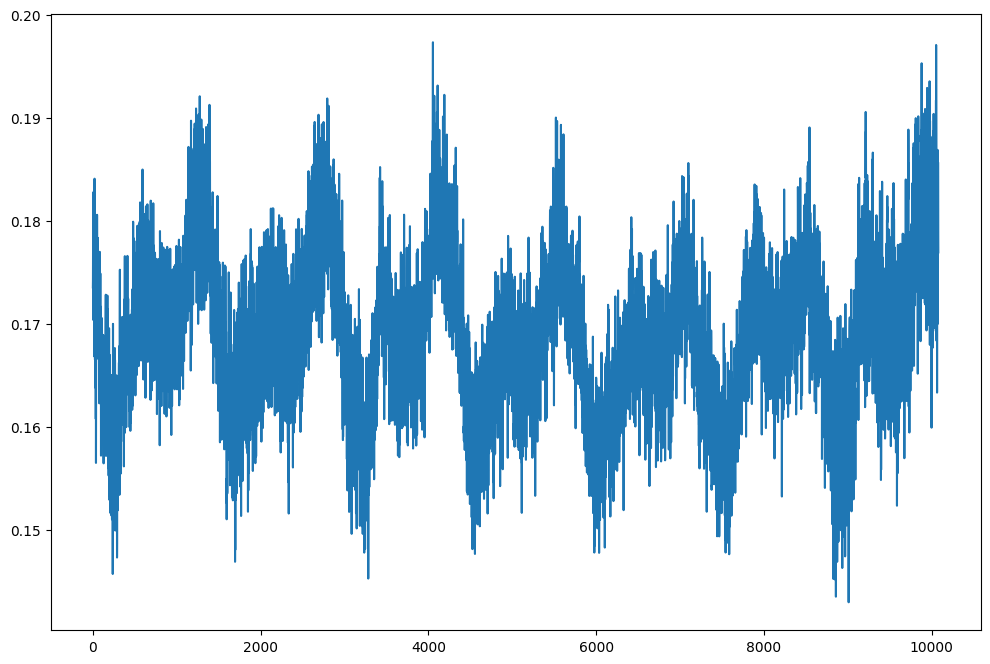

In [18]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')

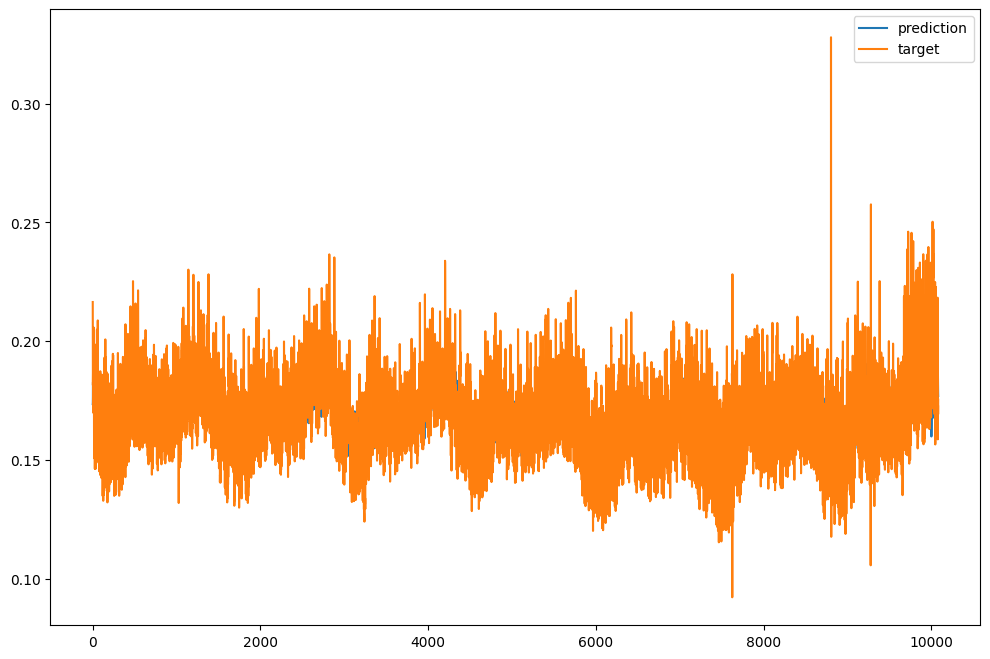

In [19]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [20]:
np.array(pred_list)

array([0.17353472, 0.17418396, 0.17657186, ..., 0.17993855, 0.17847642,
       0.17693084])

In [21]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
target

array([[0.216504],
       [0.19432 ],
       [0.181504],
       ...,
       [0.172976],
       [0.169264],
       [0.175408]])

In [22]:
print(FloatTensor(np.array(pred_list)).size(),FloatTensor(target).size())

torch.Size([10080]) torch.Size([10080, 1])


In [28]:
print(SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')

6.876708567142487 %


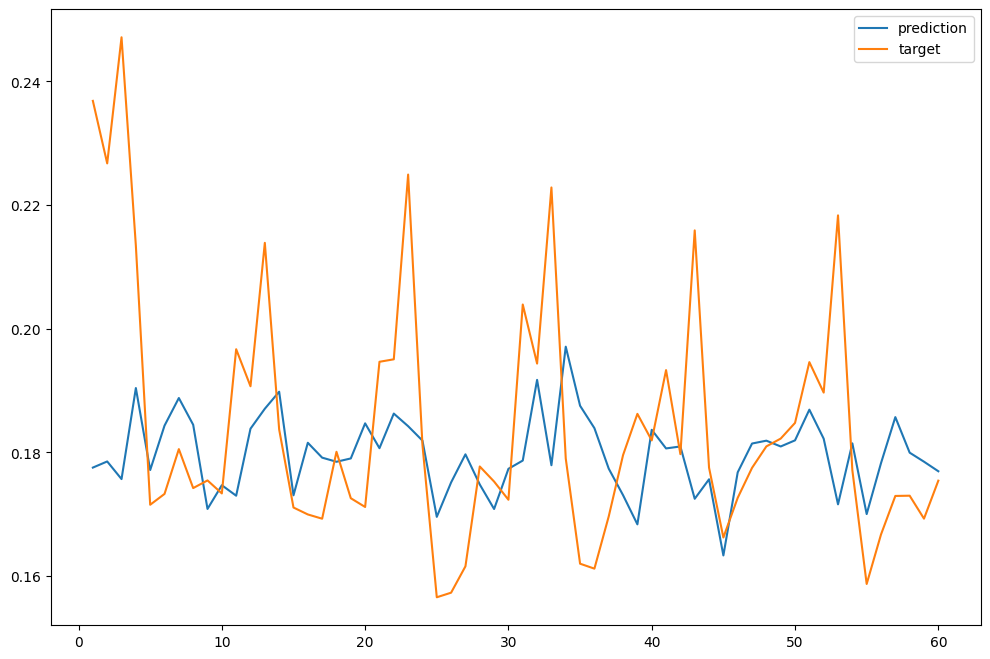

In [24]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [25]:
len(time_list)

10080

In [26]:
np.mean(time_list) 

0.26191990403901966

<font color = blue><font size = 6> Conclusion </font></font><br>
훈련을 하지 않았을때는 8퍼센트의 결과를 보였고 이해 비해서 0.3 퍼센트의 결과는 매우 좋은 결과이다 데이터의 의존성이 큰 DLinear,NLinear등은 이러한 결과가 변동성이 큰 데이터에서도 똑같이 적용될 것이라고 생각된다